In [1]:
import sys
import os
import json
import scipy
import urllib
import datetime 
import urllib3
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import simanneal as sml
import multiprocessing
import itertools
import random
import math
from multiprocessing.pool import Pool
from traitlets import link
import shapely.geometry as sg
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mp
import sklearn.cluster as skc
urllib3.disable_warnings()
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

%matplotlib inline

In [9]:
# Map Settings 
# Define colors
colors = {'blue': "#009da5", 'red': "#FE2E2E"}
# Define initial map center lat/long
center = [48.357397, 14.243544]
# Define initial map zoom level
zoom = 16
# Set Map Tiles URL
#planetMapTiles = TileLayer(url= mosaicsTilesURL)
# Create the map
m = Map(
    center=center, 
    zoom=zoom,
    #default_tiles = planetMapTiles # Uncomment to use Planet.com basemap
)
# Define the draw tool type options
polygon = {'shapeOptions': {'color': colors['blue']}}
circle = {'shapeOptions': {'color': colors['red']}} 

# Create the draw controls
# @see https://github.com/ellisonbg/ipyleaflet/blob/master/ipyleaflet/leaflet.py#L293
dc = DrawControl(
    polygon = polygon,
    circle = circle
)
# Initialize an action counter variable
actionCount = 0
AOIs = {}

# Register the draw controls handler
def handle_draw(self, action, geo_json):
    # Increment the action counter
    global actionCount
    actionCount += 1
    # Remove the `style` property from the GeoJSON
    geo_json['properties'] = {}
    # Convert geo_json output to a string and prettify (indent & replace ' with ")
    geojsonStr = json.dumps(geo_json, indent=2).replace("'", '"')
    #print(geojsonStr)
    AOIs[actionCount] = json.loads(geojsonStr)
    
# Attach the draw handler to the draw controls `on_draw` event
dc.on_draw(handle_draw)
m.add_control(dc)
m

# Partitioning into N equally sized areas that all touch at home position

Ai = 1.1927910535314457e-06
Drone 0: area of 1.1947440106821033e-06 with 14 points.
Drone 1: area of 1.1947440106821033e-06 with 19 points.
Drone 2: area of 1.1947440106821033e-06 with 19 points.
Drone 3: area of 1.1947440106821033e-06 with 19 points.
Drone 4: area of 1.1947440106821033e-06 with 19 points.
Drone 5: area of 1.1947440106821033e-06 with 21 points.
Drone 6: area of 1.1947440106821033e-06 with 23 points.


(14.242811212348942,
 14.248586212348929,
 48.355289278019363,
 48.358314278019378)

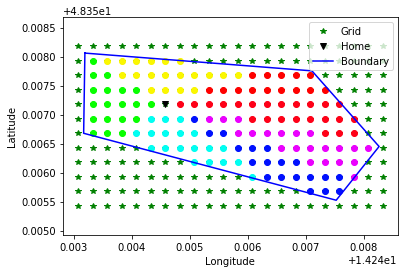

In [10]:
# Returns start & boundary
if len(AOIs) > 2:
    print("Warning: too many geometric objects selected.")
    
for i in range(1, len(AOIs)+1):    
    if AOIs[i]['geometry']['type'] == "Polygon":
        boundary = np.squeeze(np.array(AOIs[i]['geometry']['coordinates']))
    if AOIs[i]['geometry']['type'] == "Point":
        start = np.array(AOIs[i]['geometry']['coordinates'])     


# Grid size & parallelism
dx = 0.00025
dy = 0.00025
n_drones = 7

# Grid range
xmin = np.min(boundary[:, 0])
xmax = np.max(boundary[:, 0])
ymin = np.min(boundary[:, 1])
ymax = np.max(boundary[:, 1])

# x-vec
nx = int((start[0] - xmin) / dx + 1)
x = [start[0]]
xnew = xmax - 1
while xnew <= xmax:
    xnew = x[-1] + dx
    x.append(xnew)
xnew = xmin + 1
while xnew >= xmin:
    xnew = x[0] - dx
    x.insert(0, xnew)

# y-vec
ny = int((start[1] - ymin) / dy + 1)
y = [start[1]]
ynew = ymin - 1
while ynew <= ymax:
    ynew = y[-1] + dy
    y.append(ynew)
ynew = ymin + 1
while ynew >= ymin:
    ynew = y[0] - dy
    y.insert(0, ynew)

# Grid
xx, yy = np.meshgrid(x, y)
xy = np.vstack([xx.flatten(), yy.flatten()]).T

# Find points inside the boundary
boundary_path = mp.Path(boundary)
xy_inside = xy[boundary_path.contains_points(xy)]

# k-Means partitioning (partitions do not touch at the home position)
# kmeans = skc.KMeans(n_drones, random_state=0, n_jobs=-1).fit(xy_inside)
# droneIdMap = kmeans.labels_

# Partitioning #2
boundary_LR = sg.LinearRing([tuple([boundary[i, 0], boundary[i, 1]]) for i in range(boundary.shape[0])])
boundary_P = sg.Polygon(boundary_LR)
A = boundary_P.area
L = boundary_P.length
Ai = A / n_drones
print("Ai = {}".format(Ai))

r = max(xmax-xmin, ymax-ymin)
N = 1000
phi_start = 0.0
P0 = tuple([start[0] + r*np.cos(phi_start), start[1] + r*np.sin(phi_start)])

def getSegmentWithAi(start, boundary_P, P0, phi_start, N, r, Ai):
    """
    Increases a segment until it has the right area.
    
    """
    
    A_seg = Ai - 1
    for i in range(1, N):
        if A_seg > Ai:
            break
        phi = phi_start + i*2*np.pi/N
        P1 = tuple([start[0] + r*np.cos(phi), start[1] + r*np.sin(phi)])
        triangle = sg.Polygon([tuple([start[0], start[1]]), P0, P1])
        segment = triangle.intersection(boundary_P)
        A_seg = sg.Polygon(segment).area
                    
    return segment, A_seg, P1, phi          


# Do the partitioning
segmentList = []
areaList = []
areaPointsList = []
droneIdMap2 = -10*np.ones((xy_inside.shape[0], ), dtype=np.int32)
for i in range(n_drones):
    # Get segment with area Ai
    segment, A_seg, P0, phi_start = getSegmentWithAi(start, boundary_P, P0, phi_start, N, r, Ai)    
    segmentList.append(segment)
    areaList.append(A_seg)
    
    # Assign drone ids to grid points & store collection of grid points for each area
    pointList = []
    for j in range(xy_inside.shape[0]): 
        if segment.contains(sg.Point(xy_inside[j, 0], xy_inside[j, 1])):
            droneIdMap2[j] = i
            pointList.append(tuple(xy_inside[j, :]))
    
    # Append start point
    pointList.append(tuple(start))    
    areaPointsList.append(pointList)
            
            
# Check drone id map for unassigned grid points
unique, counts = np.unique(droneIdMap2, return_counts=True)
count_dict = dict(zip(unique, counts))
    
# Some stats
for i in range(n_drones):
    print("Drone {}: area of {} with {} points.".format(i, A_seg, count_dict[i]))
    
# Plot    
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(n_drones)
plt.plot(xy[:, 0], xy[:, 1], 'g*', label='Grid')

for i in range(xy_inside.shape[0]):
    droneID = droneIdMap2[i]
    if droneID != -10:
        plt.plot(xy_inside[i, 0], xy_inside[i, 1], 'go', c=cmap(droneID))

plt.plot(start[0], start[1], 'kv', label='Home')
plt.plot(boundary[:, 0], boundary[:, 1], 'b-', label='Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right')
plt.axis('equal')

# Solve the Travelling Salesman Problem for each partition

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00020          0.39     7.30%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00020          0.40     6.94%     0.15%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000          0.40     4.30%     0.00%     0:00:02    -1:59:59 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000          0.40     5.07%     0.18%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000          0.37     4.45%     0.00%     0:00:04    -1:59:57 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000          0.37     5.83%     0.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00087          0.41     7.70%     0.00%     0:00:01     0:00:00 Temperature 

(14.242811212348942,
 14.248586212348929,
 48.355289278019363,
 48.358314278019378)

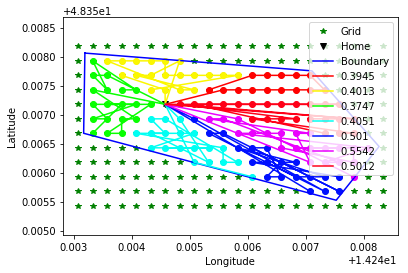

In [11]:
def distance(a, b):
    """Calculates distance between two latitude-longitude coordinates."""
    R = 3963  # radius of Earth (miles)
    lat1, lon1 = math.radians(a[0]), math.radians(a[1])
    lat2, lon2 = math.radians(b[0]), math.radians(b[1])
    return math.acos(math.sin(lat1) * math.sin(lat2) +
                     math.cos(lat1) * math.cos(lat2) * math.cos(lon1 - lon2)) * R


class TravellingSalesmanProblem(sml.Annealer):

    """Test annealer with a travelling salesman problem.
    """

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important!

    def move(self):
        """Swaps two cities in the route."""
        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]

    def energy(self):
        """Calculates the length of the route."""
        e = 0
        for i in range(len(self.state)):
            e += self.distance_matrix[self.state[i-1]][self.state[i]]
        return e
    
def solve_tsp(pointList, start):

    # Fill dict
    cities = {}
    for i in range(len(pointList)):  
        cities[str(i)] = pointList[i]
    
    # initial state, a randomly-ordered itinerary
    init_state = list(cities.keys())
    random.shuffle(init_state)

    # create a distance matrix
    distance_matrix = {}
    for ka, va in cities.items():
        distance_matrix[ka] = {}
        for kb, vb in cities.items():
            if kb == ka:
                distance_matrix[ka][kb] = 0.0
            else:
                distance_matrix[ka][kb] = distance(va, vb)

    
    tsp = TravellingSalesmanProblem(init_state, distance_matrix)
    #tsp.steps = 100000
    auto_schedule = tsp.auto(.1, steps=2000)
    tsp.set_schedule(auto_schedule)

    # since our state is just a list, slice is the fastest way to copy
    tsp.copy_strategy = "slice"
    state, e = tsp.anneal()
    
    # rotate 0 to start
    while state[0] != str(len(state)-1):
        state = state[1:] + state[:1]
        
    return state, e


# Solve
stateList = []
distList = []
for i in range(n_drones):
    state, e = solve_tsp(areaPointsList[i], start)
    state_ids = [int(el) for el in state]
    stateList.append(state_ids)
    distList.append(e)
    
# Plot
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(n_drones)
plt.plot(xy[:, 0], xy[:, 1], 'g*', label='Grid')

for i in range(xy_inside.shape[0]):
    droneID = droneIdMap2[i]
    if droneID != -10:
        plt.plot(xy_inside[i, 0], xy_inside[i, 1], 'go', c=cmap(droneID))

plt.plot(start[0], start[1], 'kv', label='Home')
plt.plot(boundary[:, 0], boundary[:, 1], 'b-', label='Boundary')

for i in range(n_drones):
    points = np.array([x for (y,x) in sorted(zip(stateList[i], areaPointsList[i]))])
    plt.plot(points[:, 0], points[:, 1], '-', c=cmap(i), label="{}".format(round(distList[i], 4)))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right')
plt.axis('equal')